**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

* <h4>Física Teórica 3</h4> 
* <h4>1er cuatrimestre 2024</h4> 
* <h4>Grupo 3: Arcuschin Moreno Nicolas, Borrell Trinidad, Brusco Agustin, Martínez Garbino Paula</h4> 

In [31]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

COLOR = "black"
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (16, 9)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams["legend.fontsize"] = 20
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["axes.grid"] = True

plt.rcParams["text.color"] = COLOR
plt.rcParams["text.color"] = COLOR
plt.rcParams["axes.labelcolor"] = COLOR
plt.rcParams["xtick.color"] = COLOR
plt.rcParams["ytick.color"] = COLOR
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

## 0. Definiciones pre-simulación

A continuación definimos las siguientes funciones:

* **`h(S)`**: calcula la energía por partícula de la red en el estado $S$ asumiendo que no hay campo magnético externo, y considerando condiciones de contorno periodicas, es decir, devuelve $\frac{H(S)}{L^2}$ con $H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1})$.

* **`metropolis(S, prob)`**: aplica el logaritmo de metropolis al estado $S$ tantas veces como sitios tiene la red. Mediante la función **`calculate_dE(S0, i, j, S)`** calcula la diferencia de energía al modificar la proyección de espín en la posición $(i, j)$.

* **`calculate_dE(S0, i, j, S)`**: calcula como se modifica la energía de la red $S$ al cambiar la proyección del espín en la posición $(i, j)$ considerando que el Hamiltoniano únicamente acopla primeros vecinos de la red, por ende, esta diferencia dependerá unicamente de estos 5 valores (el del espín modificado y sus cuatro primeros vecinos). En particular dado $H(S)$, modificando $S_{ij}$, tenemos que $\Delta E = 2 S_{ij} (S_{i-1j} + S_{ij-1} + S_{i+1j} + S_{ij+1})$.

In [2]:
@njit
def h(S: np.ndarray) -> float:
    """Calcula la energía (por partícula) de la red en el estado S."""
    H = 0
    for i in prange(S.shape[0]):
        for j in prange(S.shape[1]):
            H += -S[i, j] * (S[i - 1, j] + S[i, j - 1])
    return H / S.size  # Aca S.size ya nos dá la normalización por L^2


@njit
def calculate_dE(s0: int, i: int, j: int, S: np.ndarray) -> int:
    """Calcula la variación en la energía de la red al cambiar la proyección del spin \
en la posición (i, j).
    """
    L = S.shape[0]
    upper_i = (i + 1) % L  # Condición de periodicidad
    upper_j = (j + 1) % L  # Condición de periodicidad
    #    s3
    # s4 s0 s2
    #    s1
    s1, s2, s3, s4 = S[upper_i, j], S[i, upper_j], S[i - 1, j], S[i, j - 1]
    return 2 * s0 * (s1 + s2 + s3 + s4)


@njit
def metropolis(S: np.ndarray, prob: np.ndarray) -> tuple[np.ndarray, float, float]:
    """Aplica L² pasos del algoritmo de Metropolis al estado S de la red de L×L spines \
usando las probabilidades provistas.
    """
    dm = 0
    de = 0
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    for _ in range(S.size):
        i, j = np.random.choice(S.shape[0], 2)  # Las coordenadas al azar en [0, L)²
        sij = S[i, j]  # El spin de esa posición
        opp_sij = -sij  # El spin al que podría transicionar
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía al transicionar de sij a opp_sij
        p = np.random.random(1)
        if (  # El spin cambia su estado si:
            dE_sij <= 0  # La diferencia de energía es negativa o cero
            or (dE_sij == 4 and p < prob[0])  # Con prob[0] si dE = 4
            or (dE_sij == 8 and p < prob[1])  # Con prob[1] si dE = 8
        ):
            S[i, j] = opp_sij  # El spin cambia de estado
            de += dE_sij
            dm += opp_sij
    return S, dm / S.size, de / S.size

## 1.1. Termalización y primera simulación

A continuación definimos la función **`termalize_S(S,prob)`** que evoluciona la red `S` hasta garantizar la termalización del sistema. Esto es, cuando los estados producidos al aplicar más pasos del algoritmo de metropolis estén distribuidos según el ensamble canónico.

Para que se cumpla esta condición de forma genérica consideramos aplicar el algoritmo de metropolís hasta que el promedio de los últimos 100 incrementos de la energía y de la magnetización sean menores a $10^{-6}$. Esta condición puede entenderse intuitivamente como que le pedimos a la red que las variaciones que sufrió en $E$ y $M$ en los últimos 100 pasos se compensen entre sí, de manera que ambas cantidades estén fluctuando alrededor de valores medios definidos.

Aquí, la ventana de 100 pasos se eligió con el fin de tener una ventana que permita estudiar la historia reciente de ambas cantidades sin ser tan extensa como para que las variaciones espontaneas de $M$ cerca de la $T_c$ impidan cumplir la condición de equilibrio. De forma similar, el umbrál de $10^{-6}$ para las variaciones promedio se eligió confirmando visualmente que este permite garantizar la termalización de redes para los valores de $L$ y $T$ estudiados en este trabajo.

In [3]:
@njit
def termalize_S(S: np.ndarray, prob: np.ndarray) -> np.ndarray:
    """Aplica el algoritmo metropolis a una red S hasta que se alcanza el equilibrio \
térmico.
    """
    n = 0
    n_check = 100  # Tamaño de la ventana en la que miramos la variación de la energía
    # Nota: n_check es suficientemente chico como para que las variaciones espontaneas
    # del valor medio de M no afecten la condición de equilibrio.
    historic_de = np.zeros(n_check)
    historic_dm = np.zeros(n_check)
    while (  # Iterar mientras:
        (n < n_check)  # Hayamos hecho menos de n_check pasos
        # O si en los últimos n_check pasos:
        # las variaciones de E no se compensan
        or (np.abs(np.sum(historic_de) / (n_check)) > 1e-6)
        # las variaciones de M no se compensan
        or (np.abs(np.sum(historic_dm) / n_check) > 1e-6)
    ):
        S, dm, de = metropolis(S, prob)
        historic_de[n % n_check] = de
        historic_dm[n % n_check] = dm
        n += 1
    return S

A continuación ejemplificamos el algoritmo de termalización con una red de $256 \times 256$, partiendo de una condición inicial de "unos" y fijando la temperatura en $T = 2.2$. En cada paso (de Montercarlo) del algoritmo Metropolis guardamos además la energía y magnetización de la red para luego graficarlos.

En el gráfico podemos observar cómo en los primeros pasos de la evolución tanto $E$ como $M$ crecen o decrecen casi monotónicamente y a medida que se aplica el algoritmo de metropolis, estos se estacionan alrededor de un valor medio definido (con cierta varianza aparentemente constante).

Variando la temperatura y el tamaño de la red pudimos observar que el algoritmo presentado garantiza la termalización de la red y el mismo finaliza en el orden de los cientos de pasos.

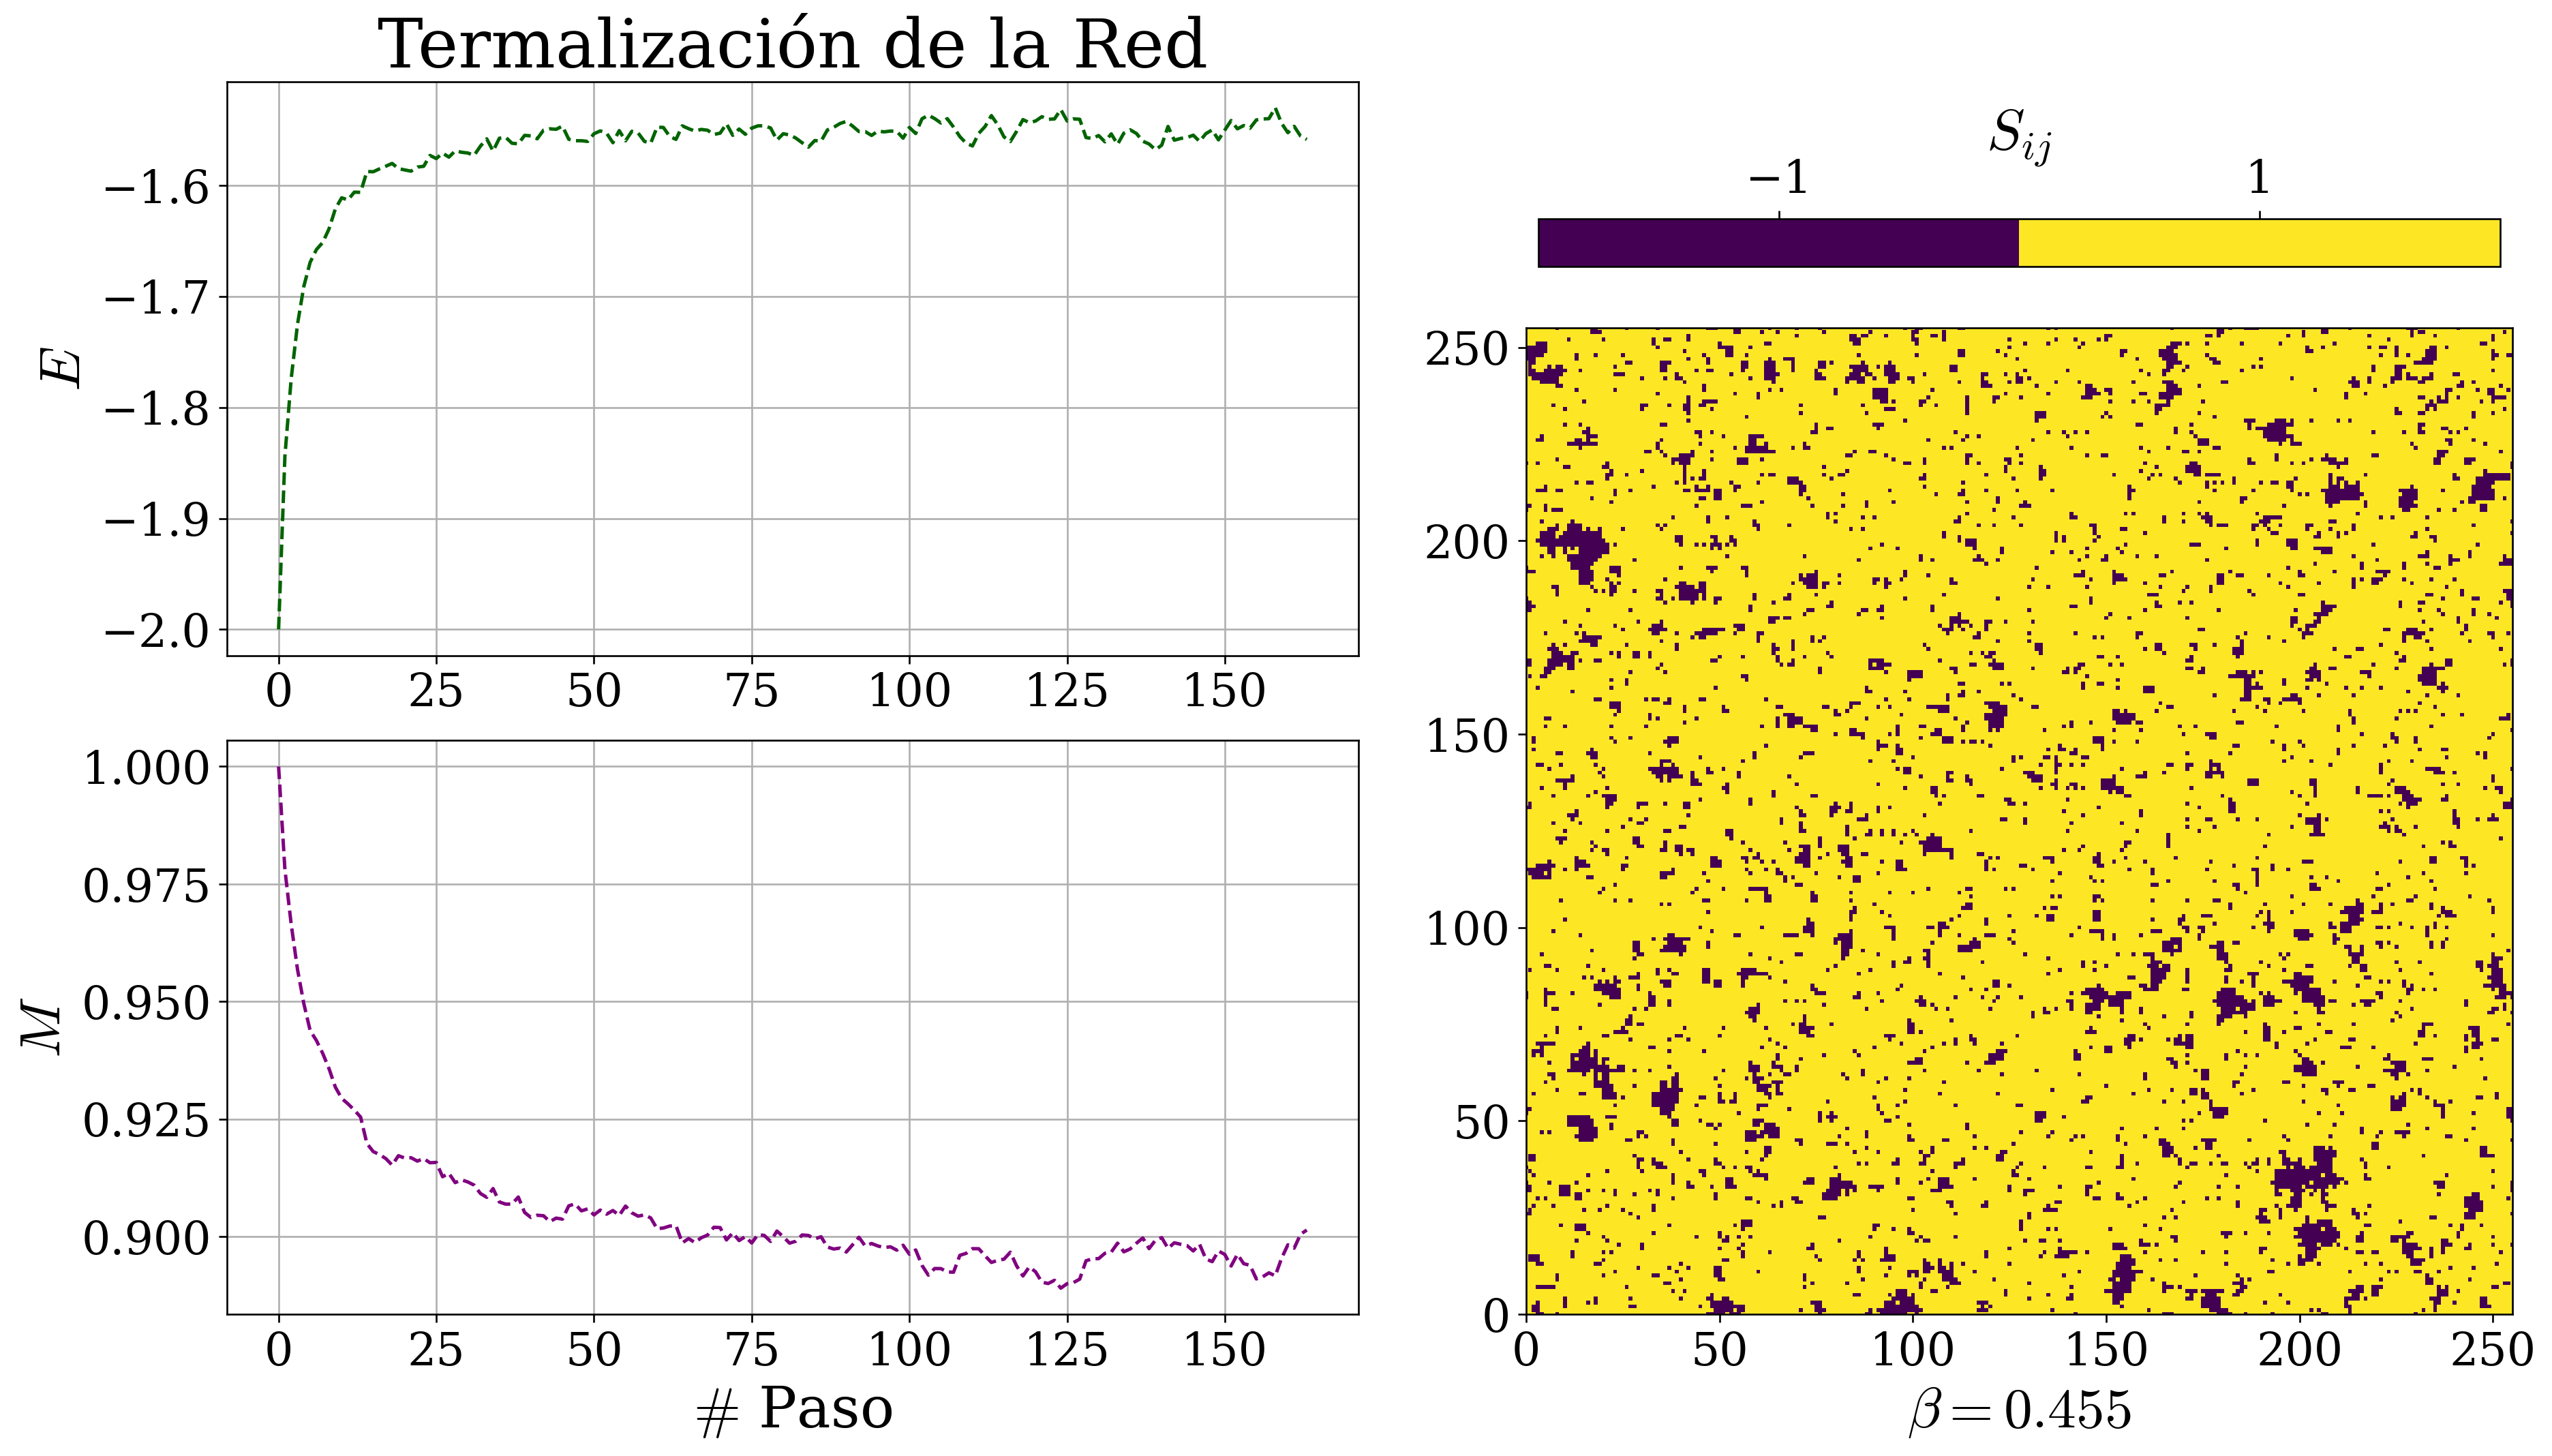

In [32]:
L = 256  # Lado de la red
T = 2.2  # Temperatura a la que vamos a termalizar
beta = 1 / T
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

# Estado inicial
if T < 2.27:
    S = np.ones((L, L), dtype=int)
else:
    S = 2 * np.random.randint(2, size=(L, L)) - 1

n = 0  # El paso del loop
M_vals = [np.mean(S), ]  # Magnetización en función del paso
E_vals = [h(S), ]  # Energia por particula en funcion del paso
n_check = 100  # Tamaño de la ventana en la que miramos la variación de la energía
historic_de = np.zeros(n_check)  # Acá vamos a almacenar los últimos valores de `de`
historic_dm = np.zeros(n_check)  # Idem para `dm`
while (
    (n < n_check)  # Dejamos pasar al menos n_check pasos para llenar una ventana
    # Luego el loop continua mientras la variación promedio de E o M en los últimos
    # n_check pasos sea mayor que el umbral:
    or (np.abs(np.sum(historic_de)/(n_check)) > 1e-6)
    or (np.abs(np.sum(historic_dm)/n_check) > 1e-6)
):
    S, dm, de = metropolis(S, prob)
    M_vals.append(M_vals[-1] + dm)  # Magnetización de S en este paso
    E_vals.append(E_vals[-1] + de)  # Energía de S en este paso
    historic_de[n%n_check] = de  # Agregamos `de` a la ventada
    n+=1

# Graficamos E, M y la red al final de la termalización.
fig, axs = plt.subplot_mosaic(
    """
    AACC
    BBCC
    """,
    # constrained_layout=True
    tight_layout=True
)
axs["A"].plot(E_vals, color="darkgreen", linestyle='--')
axs["B"].plot(M_vals, color="purple", linestyle='--')

spin_colors = axs["C"].imshow(S)
axs["C"].grid(False)
axs["C"].set_ylim(0, L - 1)
axs["C"].set_xlim((0, L - 1))
plt.colorbar(
    spin_colors, ax=axs["C"], orientation="horizontal", location="top", label="$S_{ij}$",
    boundaries=[-2, 0, 2], values=[-1, 1], ticks=[-1, 1], shrink=0.85,
)

axs["A"].set_title("Termalización de la Red")
axs["A"].set_ylabel("$E$")
axs["B"].set_ylabel("$M$")
axs["B"].set_xlabel("$\#$ Paso")
axs["C"].set_xlabel(rf"$\beta = {beta:.3g}$")
plt.show()

## 1.2. Promedios: estudio de las variaciones de los promedios en función de T y L

A continuación hicimos un estudio de las variaciones de los promedios, analizando los pasos necesarios para que el promedio sea lo suficiemntemente bueno. Para ello definimos las siguientes funciones:

* **`create_dense_domain_around_tc(temperatura_critica, n_puntos)`**: generamos un dominio de temperaturas con mayor densidad alrededor de la temperatura crítica. [DESARROLLAR]

* **`do_sim_until_convergence(S, prob)`**: nos devuelve el $n$ tal que los promedios son 'buenos' dada una red $S$. Usa la misma lógica del punto anterior donde se nos da una red $S$ termalizada y luego se aplica metropolis los $n$ pasos necesarios hasta que se cumpla que durante $500$ pasos la diferencia entre valores promedios sucesivos de energía y magnetización sean menores a $10^{-6}$. Para ese $n$ resultante podemos decir que el promedio es bueno.

* **`get_stable_ns_for_measurement(T_arr, S0)`**: esta función automatiza la obtención de pasos a dar para obtener buenos promedios para un arrglo de temperaturas. En primer lugar impone una condición inicial sobre la red $S$ (en general será matriz de unos para temperaturas bajas y matriz de valores randomizados para temperaturas altas. En esta condición inicial obtenemos la información del tamaño de la red) y la termaliza. Luego para cada temperatura obtiene el $n$ tal que el promedio es bueno llamando a la función **`do_sim_until_convergence(S, prob)`**. Finalmente devuelve el $n$ de cada temperatura en la lista **`n_promedios`**.

In [67]:
def create_dense_domain_around_tc(temperatura_critica: float, n_puntos: int):
    # # Define the range of the domain
    # x_min = temperatura_critica/2 + 0.5
    # x_max = temperatura_critica*2 - 0.5
    # # Define the density function (a Gaussian-like distribution)
    # def density_function(x, center, scale):
    #     return np.exp(-((x - center) ** 2) / (2 * scale ** 2))

    # # Generate x values
    # x_values = np.linspace(x_min, x_max, n_puntos)

    # # Compute the density values
    # scale = 0.5  # Adjust scale for desired density spread
    # density_values = density_function(x_values, temperatura_critica, scale)

    # # Normalize the density values
    # density_values /= np.sum(density_values)

    # # Create a cumulative distribution function (CDF) for the density values
    # cdf = np.cumsum(density_values)

    # # Generate the dense domain using the inverse CDF method
    # dense_domain = np.interp(np.linspace(0, 1, n_puntos), cdf, x_values)
    
    # Define the symmetry point
    distribucion = stats.norm(loc=temperatura_critica, scale=0.5)  # Gaussiana
    # Genero un array de valores equiespaciados entre 0 y 1 para samplear la ICDF
    base_domain = np.linspace(1, 0, n_puntos + 2)[1:-1]
    # Evaluo la ICDF en los valores generados
    dense_domain = distribucion.isf(base_domain)
    return dense_domain


@njit
def do_sim_until_convergence(S, prob):
    N_max = 50_000
    M = np.zeros(N_max)  # Magnetización en función del paso
    E = np.zeros(N_max)  # Energía por particula en funcion del paso
    M_avg = np.zeros_like(M)  # M_avg[i] = mean(|M[:i+1]|)
    E_avg = np.zeros_like(E)  # E_avg[i] = mean(E[:i+1])

    M[0] = np.sum(S) / S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula
    M_avg[0] = np.abs(M[0])
    E_avg[0] = E[0]

    n = 1
    average_counter = 0
    while (n < N_max) and (average_counter < 500):
    # for n in range(1, N_max):
        # if average_counter >= 500:
        #     break
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de
        M_avg[n] = np.mean(np.abs(M[:n+1]))
        E_avg[n] = np.mean(E[:n+1])
        # Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6
        # añado uno al contador de promedio
        # Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
        if (abs(E_avg[n-1] - E_avg[n]) < 1e-6) and abs(M_avg[n-1] - M_avg[n] < 1e-6):
            # Podría mejorarse pidiendo algo con respecto al error relativo
            average_counter += 1
        n += 1
    return n


def get_stable_ns_for_measurement(T_arr: np.ndarray, S0):
    n_promedios = np.zeros_like(T_arr)
    for ti in tqdm(range(T_arr.size), desc="T", total=T_arr.size):
        T = T_arr[ti]
        beta = 1 / T
        prob = np.exp(-beta * np.array([4, 8]))
        if T < 2.27:
            S = S0[0]  # T bajas
        else:
            S = S0[1]  # T altas
        S = termalize_S(S, prob)
        n_promedios[ti] = do_sim_until_convergence(S, prob)
    return n_promedios

A continuación considerando $101$ valores de temperaturas y $6$ valores de tamaño de red se coniguieron la cantidad de pasos para obtener buenos promedios. El resultado se guardó en un 'csv' llamado 'LT_matrix.csv'.

In [69]:
T_arr = create_dense_domain_around_tc(2.27, 101)
L_arr = 2**np.arange(4, 9+1)  # 16, 32, 64, 128, 256, 512

# Calculamos para todos los L
try:
    df_0 = pd.read_csv("LT_matrix.csv", index_col=0, dtype=float)
    df_0.columns = [int(L_str) for L_str in df_0.columns]
    df_0 = df_0.map(int)
except FileNotFoundError:
    df_0 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L,L))-1]
        df_0[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_0.to_csv('LT_matrix.csv')

# Calculamos de nuevos para los L más chicos que tienen mayor varianza
# y luego promediamos los resultados
try:
    df_1 = pd.read_csv("LT_matrix_1.csv", index_col=0, dtype=float)
    df_1.columns = [int(L_str) for L_str in df_1.columns]
    df_1 = df_1.map(int)
except FileNotFoundError:
    df_1 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr[:3]:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L,L))-1]
        df_1[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_1.to_csv('LT_matrix.csv')

# Promediamos los resultados repetidos
df_n = round((df_0 + df_1)/2)
df_n.fillna(df_0, inplace=True)
df_n = df_n.map(int)

In [154]:
def get_n_from_matrix(L: int, T: float, df_n: pd.DataFrame) -> int:
    L_vals = df_n.columns.to_numpy()
    T_vals = df_n.index.to_numpy()
    N_grid = df_n.to_numpy()
    
    # Buscamos los valores más cercanos:
    row_num = np.argmin(abs(T_vals - T))
    col_num = np.argmin(abs(L_vals - L))
    n_vecinos = 10
    # Promedio a n vecinos en T
    N_medio = np.mean(N_grid[max(row_num-n_vecinos//2, 0):row_num+n_vecinos//2, col_num])
    return np.round(N_medio)

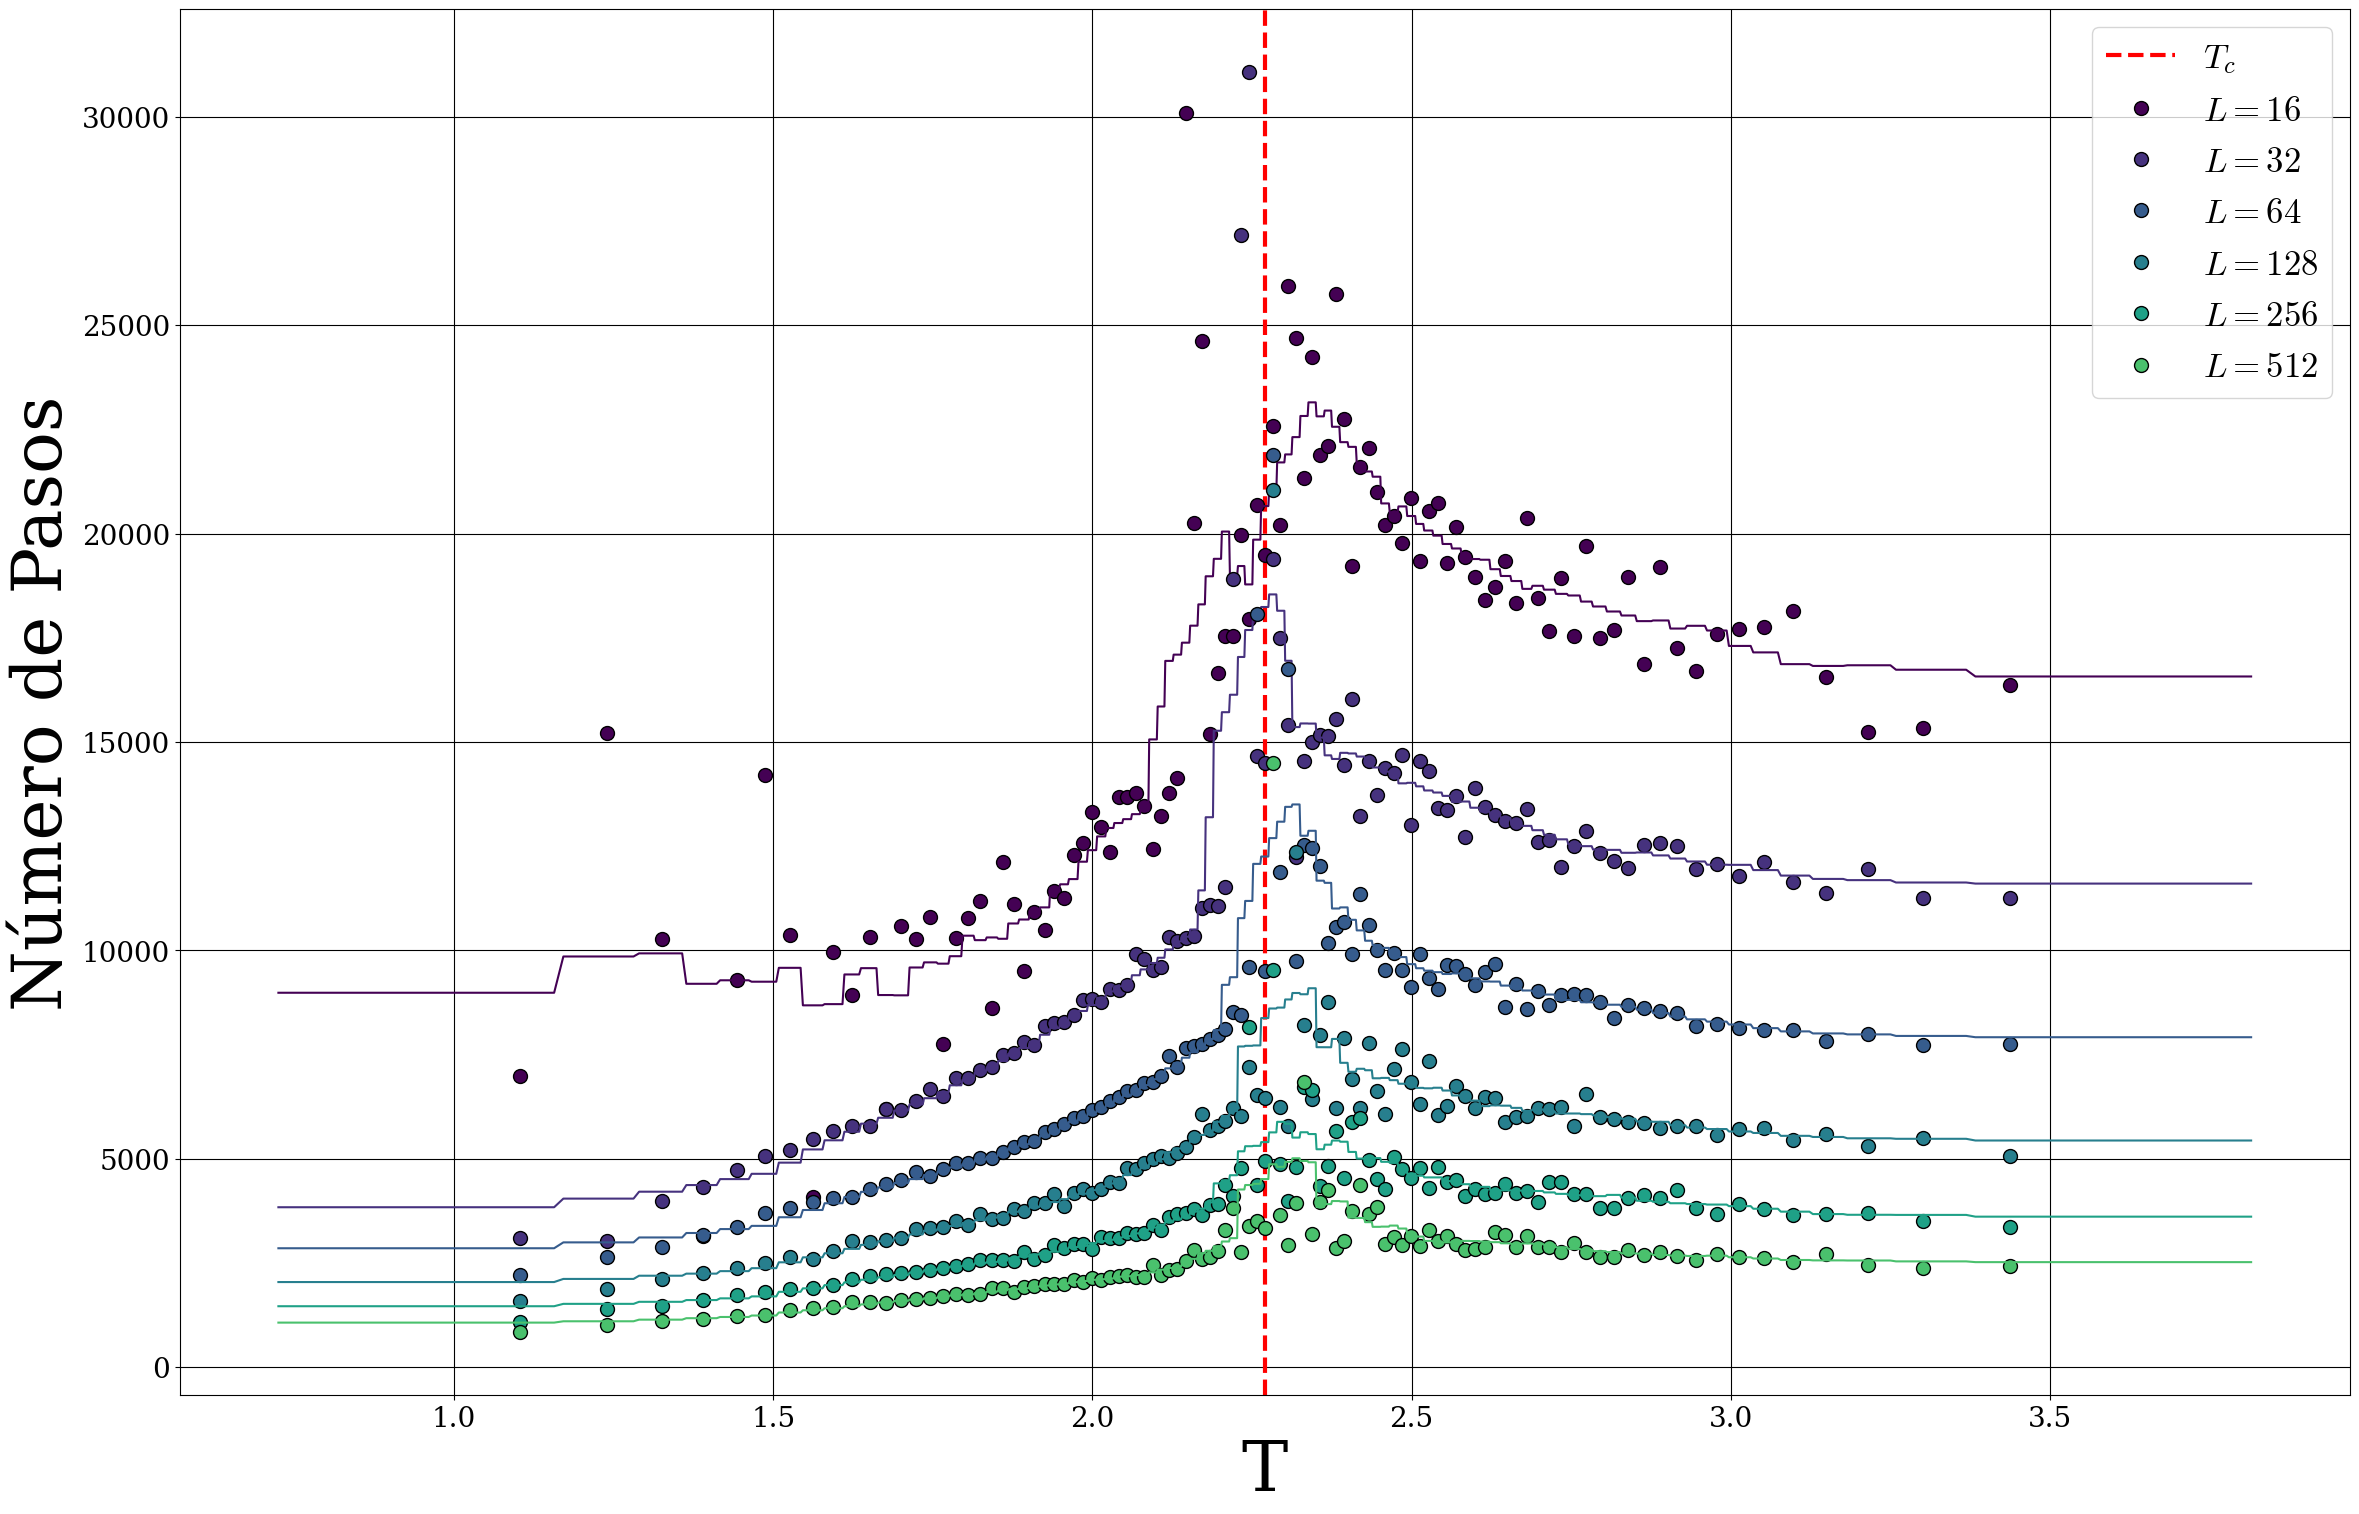

In [158]:
from matplotlib.colors import LogNorm

fig,ax = plt.subplots()
ax.axvline(2.27, color='r', ls='--', lw=3, label='$T_c$')
L_colors = cm.ScalarMappable(LogNorm(L_arr[0], L_arr[-1]*4), cmap="viridis")
T_dense = create_dense_domain_around_tc(2.27, 1000)
LT_matrix = df_n.to_numpy()
for li, L in enumerate(L_arr):
    ax.plot(
        T_arr, LT_matrix[:, li], 'o', ms=10, mec="k", mew=1, color=L_colors.to_rgba(L),
        label=f"${L = }$"
    )
    ax.plot(
        # T_dense, get_n_from_matrix(L, T_dense, df_n).flatten(), '-', color=L_colors.to_rgba(L)
        T_dense, [get_n_from_matrix(L, T, df_n) for T in T_dense], '-', color=L_colors.to_rgba(L)
    )
    # ax.text(
    #     T_arr[-3], LT_matrix[li, -3] - 200, f"{L = }",
    #     ha="left", va="top", size=40, color=L_colors.to_rgba(L),
    # )
    ax.set_ylabel('Número de Pasos')
    ax.set_xlabel('T')
ax.legend()
# ax.set_ylim(top=20_000)
# plt.colorbar(L_colors, ax=ax, ticks=L_arr, format="{x:.0f}", extend="both")
plt.show()

## 2. Transición de fase

A continuación, considerando los estudios previos, calculamos la energía media por partícula, la magnetización media, la suceptibilidad y el calor específico. La energía y magnetización media las calculamos tomando la media de estos valores sobre el sistema una vez que este termalizó y que se tomaron pasos suficientes para hacer un buen promedio. Por otro lado, la suceptibilidad y el calor específico los calculamos considerando la varianza de la energía y de la magnetización, utilizando las siguientes relaciones y que $k = 1$.

- $\langle \Delta E ^ 2 \rangle = T^2 N c_v$

- $\langle \Delta M ^ 2 \rangle = T N \chi$

Para ello usamos las funciones: 

* **`phase_transition(T, prob)`**: en esta función se termaliza una red $S$ y luego se aplica **`n_stable`** veces el algoritmo metropolis para obtener los promedios de energía y magnetización. Esto último se hace en la función **`doNstepsofSimulation(S, prob)`**, y la idea es que el valor de  **`n_stable`**  se base en el estudio previo hecho para tomar buenos promedios. Obtenemos la media y la varianza de la energía, la magnetización y la red resultante.

* **`doNstepsofSimulation(S, prob)`**: aplica el algoritmo de metropolis **`n_stable`** pasos.

In [23]:
@njit
def doNstepsofSimulation(S,N,prob):
    M = np.zeros(N)  # Magnetización en función del paso
    E = np.zeros(N)  # Energía por particula en funcion del paso
    M[0] = np.sum(S)/S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula

    for n in range(1, N):
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de

    return E,M

@njit
def phase_transition(T, n_stable, S0):
    beta = 1 / T
    dE = np.array([4, 8])  # únicos Delta_E positivos
    prob = np.exp(-beta * dE)

    #Termalizamos el sistema
    S = termalize_S(S0, prob)
    #Lo estabilizamos
    E, M = doNstepsofSimulation(S, n_stable, prob)
    # #Tomamos N muestras de la energía y la magnetización
    # E, M = doNstepsofSimulation(S, N, prob)
    
    avg_E = np.sum(E)/n_stable
    avg_M = np.sum(np.abs(M))/n_stable

    std_E = np.sqrt(np.sum((E - avg_E)**2)/(n_stable-1))
    std_M = np.sqrt(np.sum((np.abs(M) - avg_M)**2)/(n_stable-1))

    return avg_E, avg_M, std_E**2, std_M**2, S


A continuación observamos los resultados obtenidos para una red de dimensión $64$ x $64$. Usamos del punto previo la función que nos define un dominio con mayor densidad de puntos alrededor de la temperatura crítica y a su vez usando los valores obtenidos dado un valor de $T$ y $L$ para tomar buenos promedios. A su vez, considerando condiciones iniciales donde para temperaturas bajas (menores a la crítica) tenemos una matriz de unos mientras que para temperaturas altes (mayores a la crítica) tenemos una matriz aleatoria de unos y menos unos.

In [51]:
L = 64  # Dimensiones de la red

T_arr = create_dense_domain_around_tc(2.27, 50)
mean_E_T = np.zeros(len(T_arr))
mean_M_T = np.zeros(len(T_arr))
var_E_T = np.zeros(len(T_arr))
var_M_T = np.zeros(len(T_arr))

In [52]:
T_threshold = 2.27

T = T_arr[0]
S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]
if T < T_threshold:
    S = S0[0] #T bajas
else:
    S = S0[1] #T altas

for i, T in tqdm(enumerate(T_arr)):
    n_stable = int(pd.read_csv('LT_matrix.csv', index_col='Unnamed: 0')[str(L)].to_numpy()[i])
    mean_E, mean_M, var_E, var_M, S = phase_transition(T, n_stable, S)
    mean_E_T[i] = mean_E
    mean_M_T[i] = mean_M
    var_E_T[i] = var_E
    var_M_T[i] = var_M

0it [00:00, ?it/s]

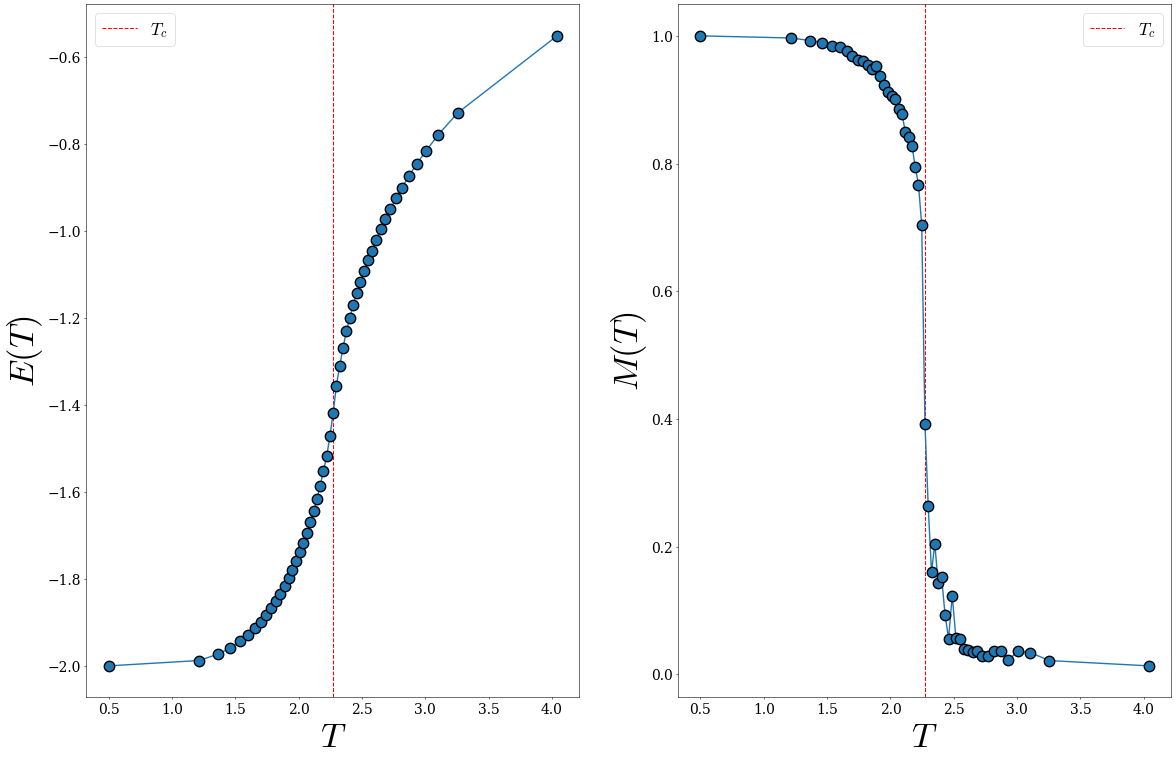

In [42]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$E(T)$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$M(T)$')
plt.grid()
plt.legend()
plt.show()

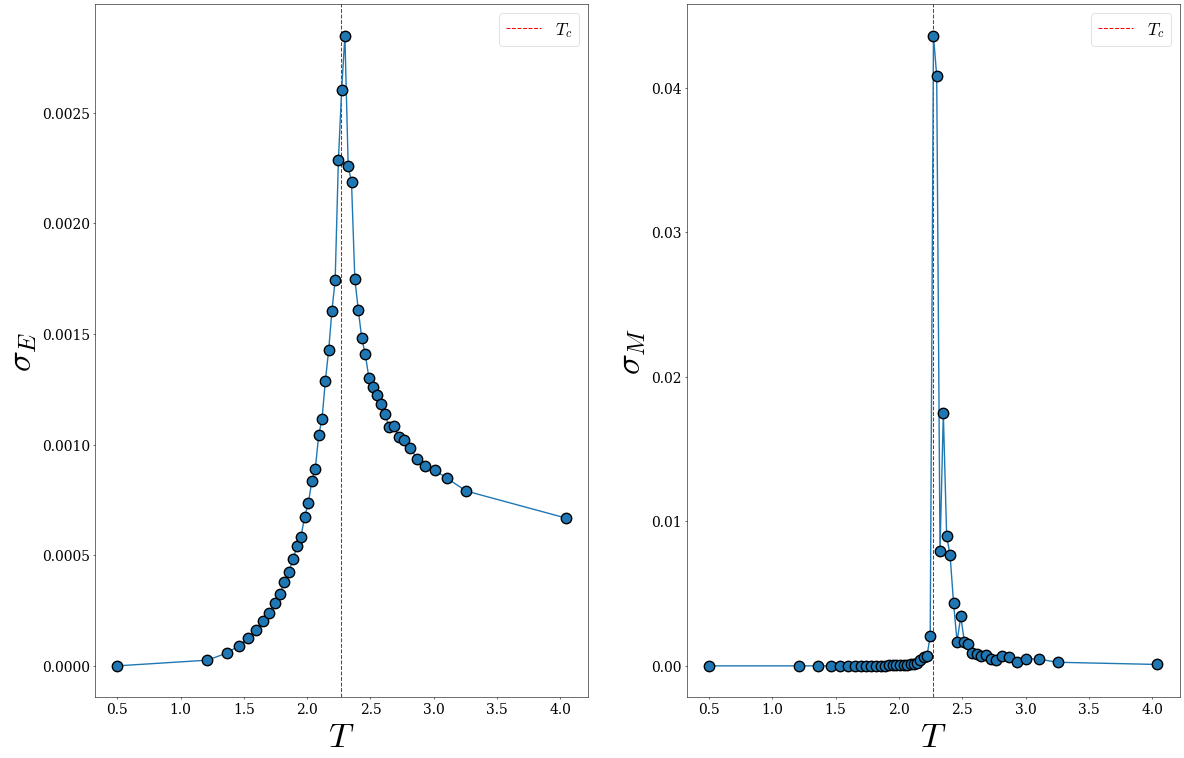

In [43]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$\sigma_E$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\sigma_M$')
plt.legend()
plt.grid()
plt.show()

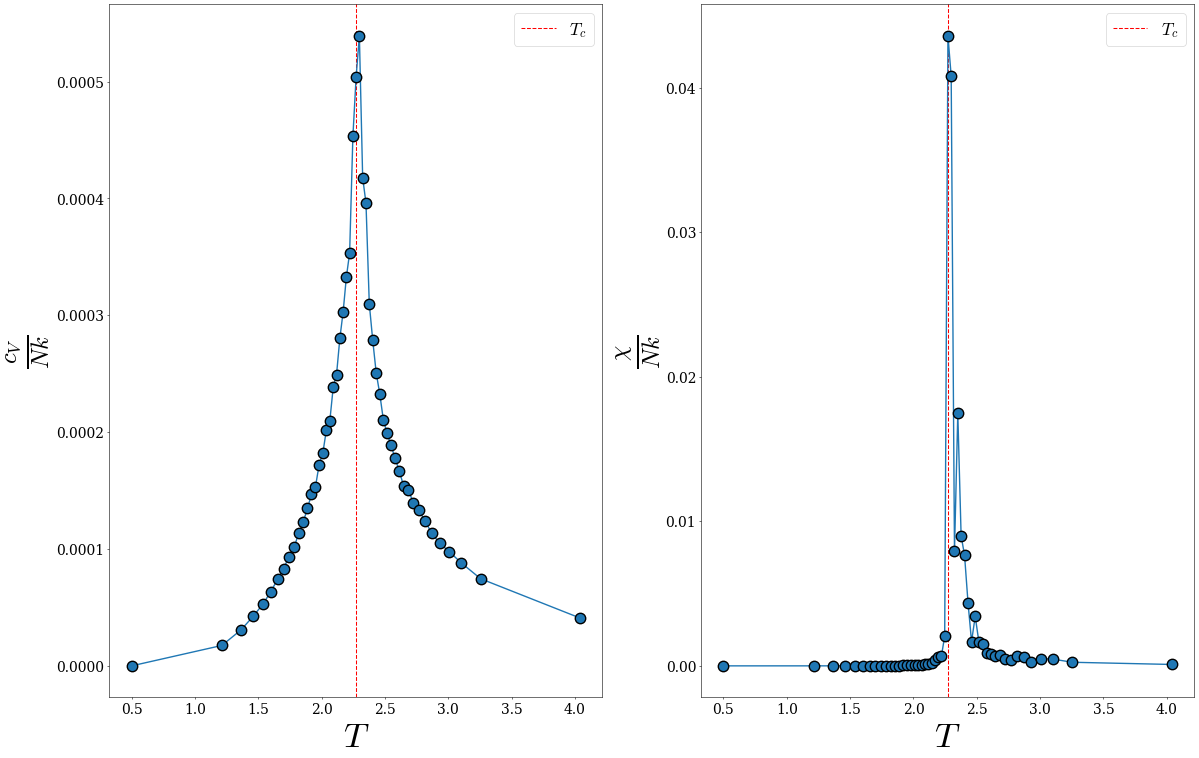

In [44]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T*(1/T_arr**2), 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{c_V}{N}$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{\chi}{N}$')
plt.grid()
plt.legend()
plt.show()

## 3. Correlaciones

In [23]:
@njit
def cor(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r, _ in enumerate(cor_vec):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)


@njit
def metropolis2(S: np.ndarray, prob: np.ndarray):
    # Aplica el algoritmo de Metropolis al estado S
    # if N == S.size:
    #    return S, h(S), np.mean(S)
    dm = 0
    dc = np.zeros(S.shape[0] // 2)
    for _ in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        # dE_sij = calculate_dE(opp_sij, i, j, S) - calculate_dE(
        #     sij, i, j, S
        # )
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)
        c_viejo = cor(S)  # [Optim] Levantar de cuenta anterior?
        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            dm += opp_sij
            dc += cor(S) - c_viejo  # [Optim] Se podría calcular la contribución especifica de este spin
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
    # la red, es decir, L cuadrado veces.
    # return metropolis(S, prob, N + 1)
    return S, dm / S.size, dc / S.size

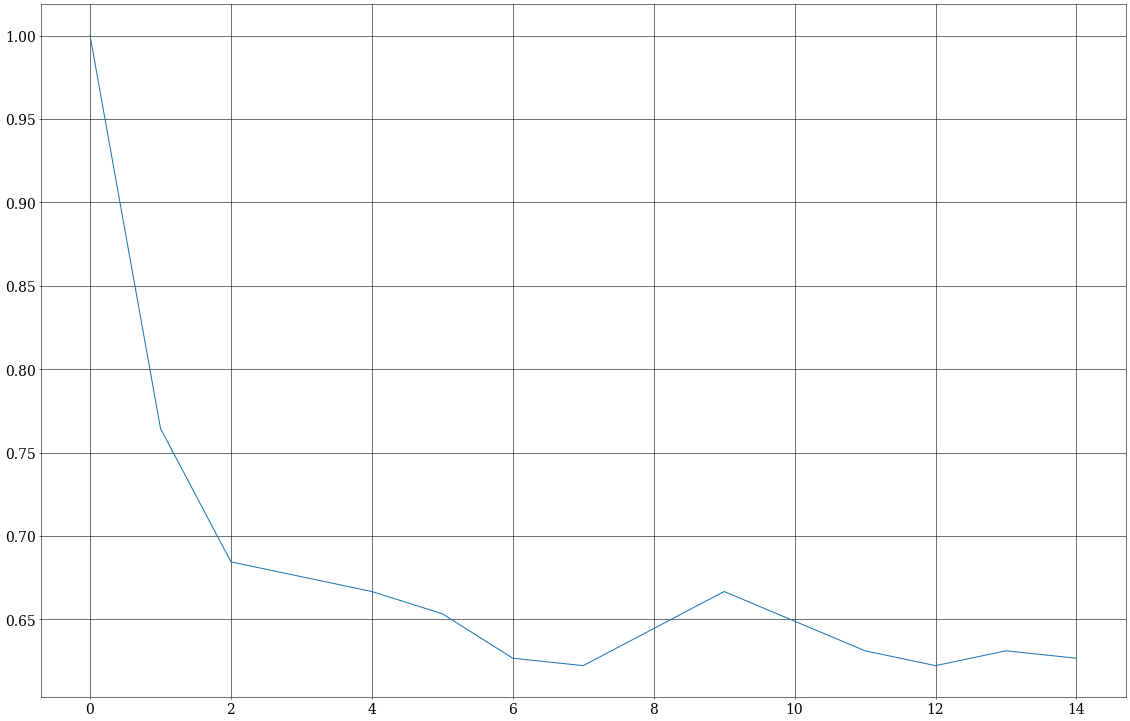

In [24]:
plt.plot(cor(S))
plt.show()

In [25]:
L = 30

nequilibrio = 1_000
npromedio = 500

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion


def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)

print("Longitud de correlacion:")

for T in tqdm([1.5, 2.3, 3], desc="Temperaturas"):

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor(S)

    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, covarianza = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print("T={} => {}".format(T, parametros[1]))

    plt.plot(r_vals, fitcor(r_vals, parametros[0], parametros[1]), label="T={}".format(T))

plt.xlabel("r")
plt.ylabel("funcion de correlacion")
plt.legend()
plt.show()

Longitud de correlacion:


Temperaturas:   0%|          | 0/3 [00:00<?, ?it/s]

Termalizando:   0%|          | 0/1000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/499 [00:00<?, ?it/s]

SystemError: CPUDispatcher(<function metropolis2 at 0x74947e726c00>) returned a result with an exception set